# 📰 News Article Similarity Analysis using NLP 🧠📊

## 🎯 Objective
This notebook explores text similarity among news articles using NLP techniques. We will:

✅ Convert text into numerical vectors using pre-trained **GloVe embeddings**.  
✅ Reduce dimensionality for visualization using **PCA**.  
✅ Apply **K-Means clustering** to group similar news articles.  

---

## 🔍 Why GloVe?
GloVe (**Global Vectors for Word Representation**) provides **dense vector embeddings** trained on a large corpus, allowing us to capture the **semantic meaning** of words efficiently. 🏆✨  

Using GloVe, we can **transform text into meaningful numerical representations** for further processing and clustering. 🚀📖


In [1]:
# 📥 Import necessary libraries
# ⬇️ Download stopwords for text cleaning
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pandas as pd
import re
import urllib.request
import os
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import zipfile
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## 📊 Data Overview
The dataset consists of news articles with the following columns:

📰 **title**: The headline of the news article.  
📄 **content**: The full text of the article.  

🎯 Our goal is to **analyze the similarity between articles** and **group them into clusters** for better understanding. 🔍🤖  


In [2]:

# download the dataset
!wget https://raw.githubusercontent.com/mage-ai/datasets/refs/heads/master/news_articles.csv


--2025-04-05 17:19:58--  https://raw.githubusercontent.com/mage-ai/datasets/refs/heads/master/news_articles.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18236066 (17M) [text/plain]
Saving to: ‘news_articles.csv’

news_articles.csv   100%[===================>]  17.39M  46.8MB/s    in 0.4s    

2025-04-05 17:19:59 (46.8 MB/s) - ‘news_articles.csv’ saved [18236066/18236066]



In [3]:

# Load dataset
df = pd.read_csv('news_articles.csv')
# Display basic dataset information
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55335 entries, 0 to 55334
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   topic           55335 non-null  object
 1   headline        55334 non-null  object
 2   author          45881 non-null  object
 3   link            55335 non-null  object
 4   description     49630 non-null  object
 5   published date  55335 non-null  object
dtypes: object(6)
memory usage: 2.5+ MB
None


In [4]:
df.head()

,topic,headline,author,link,description,published date
0,entertainment,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
1,entertainment,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
2,entertainment,Morgan Freeman 'Devastated' That Sexual Harass...,Ron Dicker,https://www.huffingtonpost.com/entry/morgan-fr...,"""It is not right to equate horrific incidents ...",2018-05-26
3,entertainment,What To Watch On Amazon Prime That’s New This ...,Todd Van Luling,https://www.huffingtonpost.com/entry/amazon-pr...,There's a great mini-series joining this week.,2018-05-26
4,entertainment,Mike Myers Reveals He'd 'Like To' Do A Fourth ...,Andy McDonald,https://www.huffingtonpost.com/entry/mike-myer...,"Myer's kids may be pushing for a new ""Powers"" ...",2018-05-26


In [15]:
df['topic'].value_counts()

,count
topic,
politics,17243
wellness,12824
entertainment,11447


## 🛠️ Text Preprocessing
✅ **Lowercasing** to standardize words. 🔡  
✅ **Removing special characters and punctuation** to clean the text. ✂️🧹  


In [5]:
# Handling missing values
df.dropna(inplace=True)

# df['description'].isna().sum()


# Text Cleaning Function
# Lowercasing
# Remove non-word characters
def clean_text(text):

  text = text.lower()
  text = re.sub(r'\W+', ' ', text)
  text.split()
  return text








#apply the above function on the dataframe

df['description'] = df['description'].apply(clean_text)



In [6]:
df['description'].head()

,description
0,of course it has a song
1,the actor and his longtime girlfriend anna ebe...
2,it is not right to equate horrific incidents ...
3,there s a great mini series joining this week
4,myer s kids may be pushing for a new powers fi...


## 🏆 GloVe-Based Embeddings  
Each article is converted into a **100-dimensional numerical vector** using **GloVe embeddings**. 🔢✨  

🔹 If a word is **found** in GloVe, its corresponding **vector** is used. ✅  
🔹 If **no words** in an article match the GloVe vocabulary, a **zero vector** is assigned. ⚠️0️⃣  

Using these vectors, we can numerically represent text for further **analysis and clustering**. 📊🔍🚀  


In [7]:


url = 'https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip'
output = os.path.join(os.getcwd(), 'glove.6B.zip')  # Save to the current working directory

urllib.request.urlretrieve(url, output)




# Unzip the file
with zipfile.ZipFile('./glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('./glove')


In [8]:

# Load GloVe Embeddings
glove_path = "glove/glove.6B.100d.txt"  # Change if using a different version


def load_glove_embeddings(glove_path):
    embeddings_index = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            embeddings_index[word] = vector
    return embeddings_index




glove_embeddings = load_glove_embeddings(glove_path)




In [9]:

# Convert articles to vectors

def text_to_vector(text, glove_embeddings, dim=100):
    words = word_tokenize(text)
    vectors = [glove_embeddings[word] for word in words if word in glove_embeddings]

    if len(vectors) == 0:
        return np.zeros(dim)

    return np.mean(vectors, axis=0)


df['vector'] = df['description'].apply(lambda x: text_to_vector(x, glove_embeddings))

df['vector']


,vector
0,"[-0.15373266, 0.08930833, 0.5833166, -0.117614..."
1,"[0.024923969, -0.20724551, 0.12029986, -0.1336..."
2,"[-0.046309713, 0.059210245, 0.32394513, -0.219..."
3,"[-0.19322567, 0.2676986, 0.3063531, -0.1657436..."
4,"[0.028878506, 0.26947835, 0.31404686, -0.22613..."
...,...
55322,"[-0.18712772, 0.2105692, 0.33348817, -0.140834..."
55329,"[-0.15099329, 0.19419569, 0.39513165, -0.27170..."
55331,"[-0.061152417, 0.4294191, 0.32649106, -0.20653..."
55332,"[-0.08797747, 0.23292542, 0.28456748, -0.10876..."


## ℹ️ Understanding PCA for Dimensionality Reduction  

### Why PCA? 🤔  
When working with **high-dimensional data**, it’s difficult to visualize and analyze patterns. **Principal Component Analysis (PCA)** helps by reducing the number of dimensions while **preserving important information**.  

### How Does It Work? ⚙️  
PCA transforms our **high-dimensional word embeddings** (100 dimensions) into **2 principal components** that capture most of the variance in the data. This allows us to **visualize articles in a 2D space**, making clustering more interpretable.  

🎯 **Goal:** Reduce dimensionality while retaining the most important information for better visualization and clustering.  
📊 **Next Step:** We’ll plot the articles in a 2D space to see if meaningful patterns emerge! 🚀  


In [10]:
# Reduce to 2D for visualization
x = np.stack(df['vector'].values)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(x)
# Store in DataFrame
df['pca_1'] = X_pca[:, 0]
df['pca_2'] = X_pca[:, 1]
df.head()



,topic,headline,author,link,description,published date,vector,pca_1,pca_2
0,entertainment,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,of course it has a song,2018-05-26,"[-0.15373266, 0.08930833, 0.5833166, -0.117614...",-0.627277,0.350410
1,entertainment,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,the actor and his longtime girlfriend anna ebe...,2018-05-26,"[0.024923969, -0.20724551, 0.12029986, -0.1336...",0.925819,0.536900
2,entertainment,Morgan Freeman 'Devastated' That Sexual Harass...,Ron Dicker,https://www.huffingtonpost.com/entry/morgan-fr...,it is not right to equate horrific incidents ...,2018-05-26,"[-0.046309713, 0.059210245, 0.32394513, -0.219...",0.034187,0.007075
3,entertainment,What To Watch On Amazon Prime That’s New This ...,Todd Van Luling,https://www.huffingtonpost.com/entry/amazon-pr...,there s a great mini series joining this week,2018-05-26,"[-0.19322567, 0.2676986, 0.3063531, -0.1657436...",0.148285,0.341637
4,entertainment,Mike Myers Reveals He'd 'Like To' Do A Fourth ...,Andy McDonald,https://www.huffingtonpost.com/entry/mike-myer...,myer s kids may be pushing for a new powers fi...,2018-05-26,"[0.028878506, 0.26947835, 0.31404686, -0.22613...",-0.046244,0.054590


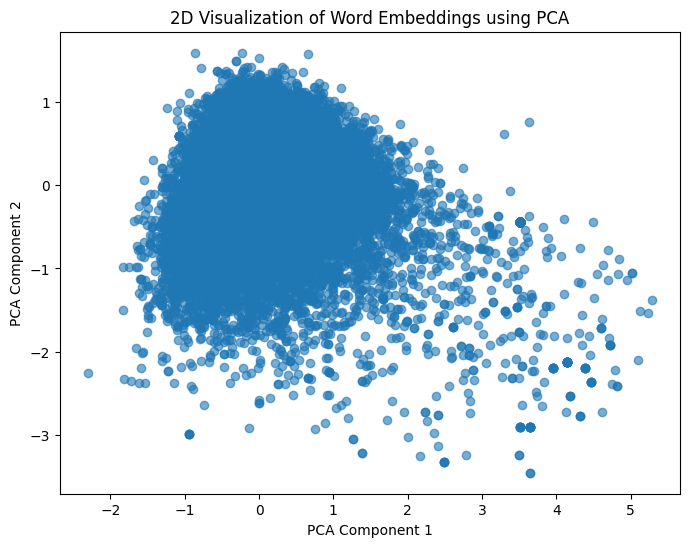

In [12]:
# display the result in 2d diagram

plt.figure(figsize=(8,6))
plt.scatter(df['pca_1'], df['pca_2'], alpha=0.6)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("2D Visualization of Word Embeddings using PCA")
plt.show()

## ℹ️ Understanding K-Means Clustering  

### Why Clustering? 🧐  
Once we have numerical representations of articles, we want to **group similar news articles together** based on their content. **K-Means clustering** is a powerful unsupervised learning algorithm that does exactly this!  

### How Does K-Means Work? ⚙️  
1️⃣ Choose the number of clusters (**k**)  
2️⃣ Assign each data point (news article) to the nearest cluster center  
3️⃣ Recalculate the cluster centers based on assigned points  
4️⃣ Repeat until cluster assignments stop changing  

### Choosing the Right k 📊  
We use the **Elbow Method** to find the **optimal number of clusters**. This helps prevent **overfitting** (too many clusters) or **underfitting** (too few clusters).  

🎯 **Goal:** Assign each article to a cluster and visualize the grouping! Let’s see if similar news topics naturally emerge. 🔍📰  


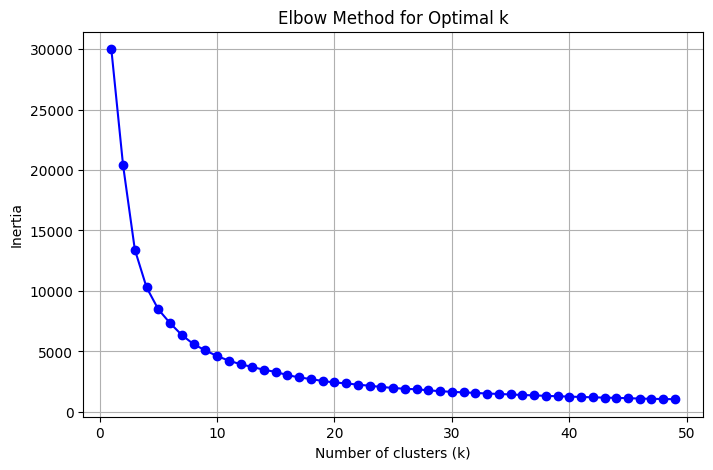

In [13]:
# Determine the optimal number of clusters using Elbow Method

x = df[['pca_1', 'pca_2']]

k_list = []

k_range = range(1,50)
for k in range(1, 50):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(x)
    k_list.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, k_list, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

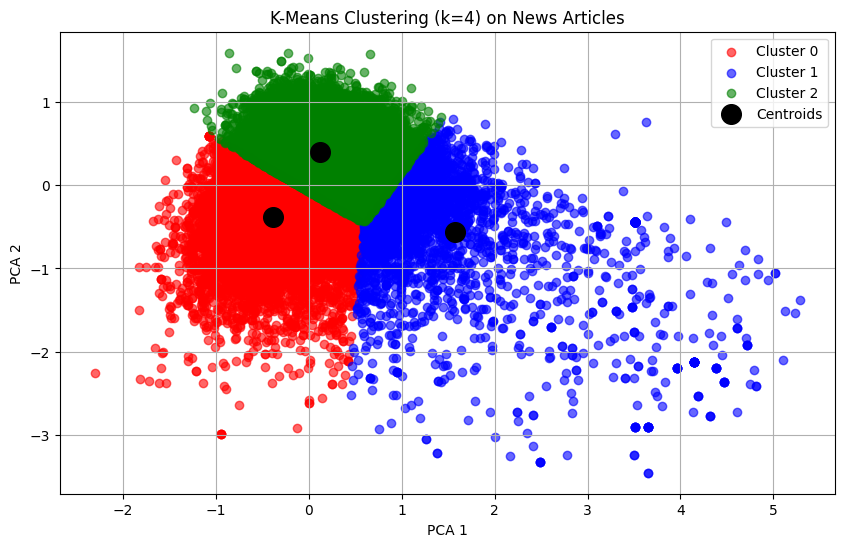

In [21]:
# Apply K-Means with optimal k (let's assume 4 based on the Elbow Method)



# NOTE: i used k=3 and then i got better results


# Visualizing Clusters
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(x)

plt.figure(figsize=(10, 6))
colors = ['red', 'blue', 'green']

for i in range(3):
    cluster_data = df[df['cluster'] == i]
    plt.scatter(cluster_data['pca_1'], cluster_data['pca_2'],
                label=f'Cluster {i}', c=colors[i], alpha=0.6)

centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            s=200, c='black', marker='o', label='Centroids')


plt.title("K-Means Clustering (k=4) on News Articles")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.show()

## ℹ️ Visualizing Clusters with Word Clouds  (Optional Section)

### Why Use Word Clouds? 🌥️🔠  
After clustering the news articles, it’s helpful to **understand the key themes** in each cluster. A **word cloud** is a simple but effective way to visualize the most common words in each group.  

### How Does It Work? ⚙️  
1️⃣ We **extract the text** from all articles in a cluster.  
2️⃣ We **count word frequencies**, giving more importance to frequently occurring words.  
3️⃣ A **word cloud** is generated, where **larger words** indicate higher frequency in that cluster.  

### What Can We Learn? 🤔  
- Identify **dominant keywords** in each cluster.  
- Get **insights into topic differences** between clusters.  
- Verify if our **K-Means clustering makes sense** based on meaningful word groupings.  

🎯 **Goal:** Use word clouds to quickly interpret the characteristics of each news category! ☁️📰🔍  


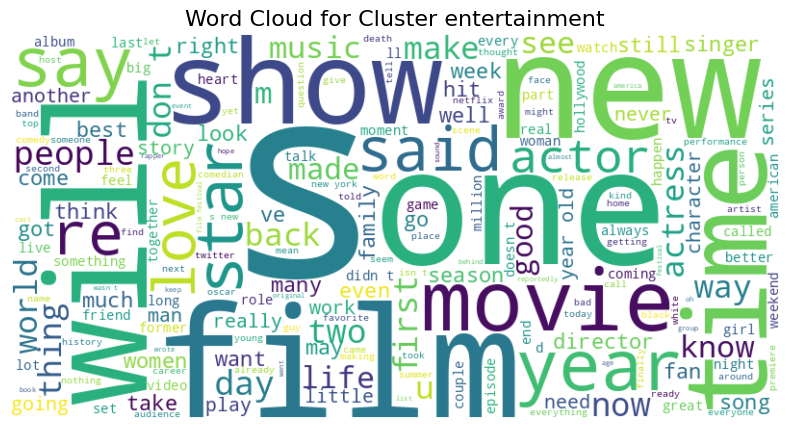

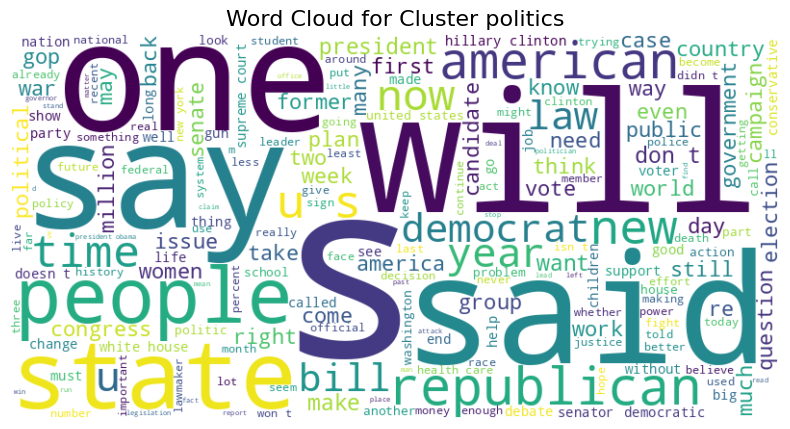

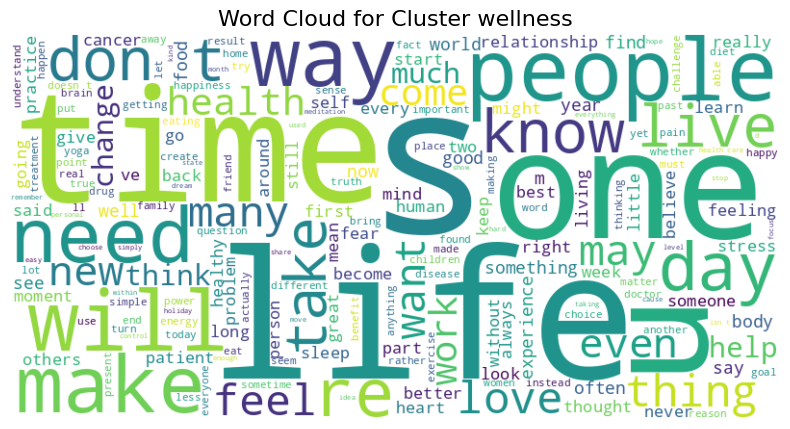

In [20]:
# Function to generate word cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_word_cloud(text, cluster_num):
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis'
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {cluster_num}', fontsize=16)
    plt.show()

for i in df['topic'].unique():
    cluster_texts = df[df['topic'] == i]['description'].dropna().astype(str)
    combined_text = " ".join(cluster_texts)
    generate_word_cloud(combined_text, i)




# Generate for each cluster


🧐 Critical Thinking & Discussion: Interpreting Our Results 💡📊📰

### 1️⃣ PCA Visualization Analysis
#### 🔍 Question:
Looking at the PCA Projection of News Articles, we see that the data is spread out but still has some overlapping areas.

- What does this distribution tell us about the underlying structure of the articles?
- Do you think reducing dimensionality to 2 components sufficiently preserves the key variations in the dataset? Why or why not?


### 2️⃣ Choosing the Optimal Number of Clusters
#### 📊 Question:
The Elbow Method plot suggests a decreasing trend in distortion as k increases.

- Based on the curve, what would you choose as the optimal k value?
- Why does the distortion decrease as k increases, and why shouldn’t we always choose a very high k?

### 3️⃣ Interpreting Clusters of News Articles
#### 📰 Question:
After applying K-Means clustering, the PCA-reduced plot shows four distinct clusters.

- How well-separated do the clusters appear? Do they seem meaningful?
- What possible themes might each cluster represent in terms of news content? How could we validate our assumptions about these themes?






